<a href="https://colab.research.google.com/github/amd257/COVID-detection-using-CNNs/blob/FinalRound/ParallelSequentialModel_ThreeLabel_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Compressed Three Label Classification Dataset file is stored at: https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0
!wget https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0

--2021-03-08 16:29:31--  https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n17olwvllwbnyl6/threelabeldataset.zip [following]
--2021-03-08 16:29:31--  https://www.dropbox.com/s/raw/n17olwvllwbnyl6/threelabeldataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc89ee7d42041064268000546eae.dl.dropboxusercontent.com/cd/0/inline/BKTK3WWW3eWmrXIeTsFjPG1dwoItCHLox7DMobWv7IEhTr-xVcb_6ERaf0huxYXHwvKnQnm96T0btTliODiVLcFW0F9Q5opDjq1UTzAdnmphEi0TTAYydXBNjLXqaMoqZJLZfH8-0Tf1YQ4jcQHcwyHS/file# [following]
--2021-03-08 16:29:32--  https://uc89ee7d42041064268000546eae.dl.dropboxusercontent.com/cd/0/inline/BKTK3WWW3eWmrXIeTsFjPG1dwoItCHLox7DMobWv7IEhTr-xVcb_6ER

In [ ]:
!unzip /content/threelabeldataset.zip?dl=0   #Extracting the compressed dataset file

In [36]:
#Importing all the libraries required for preprocessing, training and evaluation of the model
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory #Importing Functions for image preprocessing from keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau #Importing Functions for early stopping and learning rate reduction
from sklearn.utils import class_weight #Importing functions for computing class weights from scikit learn class_weight module
from keras.utils import plot_model
from keras.preprocessing import image
from keras.layers import *
from keras.models import * #Importing the functions required for creating the model
import matplotlib.pyplot as plt #For plotting the training and validation loss and accuracy graphs
import numpy as np
import pandas as pd

In [37]:
train_images_path = "ThreeLabelDataset/Train"
validation_images_path = "ThreeLabelDataset/Validation"
test_images_path = "ThreeLabelDataset/Test"
image_height = 100
image_width = 100

In [38]:
#Training data augmentation before feeding it to the CNN model
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,  #flipping will add more variations to the data and it will help fight overfitting as welll
    )

#Preprocessing the training dataset
train_dataset= train_datagen.flow_from_directory(
    train_images_path,
    target_size = (image_height,image_width), 
    batch_size = 32,
    color_mode="grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= train_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", train_dataset.class_indices)

Found 3108 images belonging to 3 classes.
Input Shape:  (100, 100, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


In [39]:
validation_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the validation images 

#Preprocessing the validation dataset
validation_dataset = validation_datagen.flow_from_directory(
    validation_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= validation_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", validation_dataset.class_indices)

Found 388 images belonging to 3 classes.
Input Shape:  (100, 100, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


In [40]:
test_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the test images 

#Preprocessing the testing dataset
test_dataset = test_datagen.flow_from_directory(
    test_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= test_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", test_dataset.class_indices)

Found 312 images belonging to 3 classes.
Input Shape:  (100, 100, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


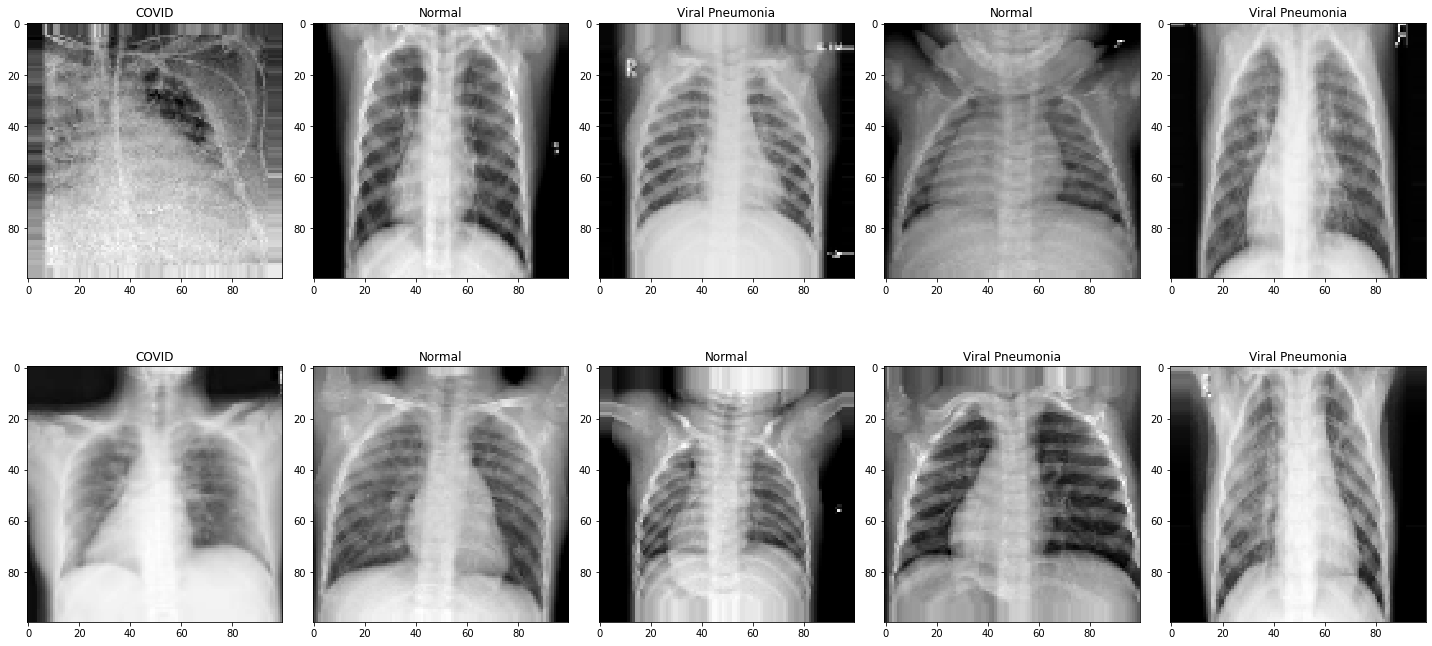

In [41]:
#Visualization of Preprocessed Data
plt.figure(figsize=(20, 10))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_dataset:
        image = X_batch[0]        
        dic = {0: 'COVID', 1:'Normal', 2:'Viral Pneumonia'}
        img_index = np.argmax(Y_batch) #to get index of the image label 
        plt.title(label= dic.get(img_index))
        plt.axis('on')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [43]:
#Creating the parallel sequential model
input_shape = inp_shape
input=Input(shape = input_shape) 
# used to be (256,256,1) but that led to too many parameters, changed to (100,100,1) to make model run
convs=[]
parrallel_kernels=[3,5,7]

for i in range(len(parrallel_kernels)):
  conv = Conv2D(128, parrallel_kernels[i],padding = 'same',activation='relu',input_shape=input_shape,strides=1)(input)
  convs.append(conv)

output = Concatenate()(convs)
conv_model = Model(input,output)

In [44]:
model = Sequential()
model.add(conv_model) # Added the conv_model with the parallel kernels to the sequential model

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='sigmoid')) #sigmoid/softmax for this layer 
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.input.shape)
model.summary()

(None, 100, 100, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 100, 100, 384)     11008     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 98, 98, 64)        221248    
_________________________________________________________________
activation_6 (Activation)    (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 47, 47, 32)        18464     
_________________________________________________________________
activation_7 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None

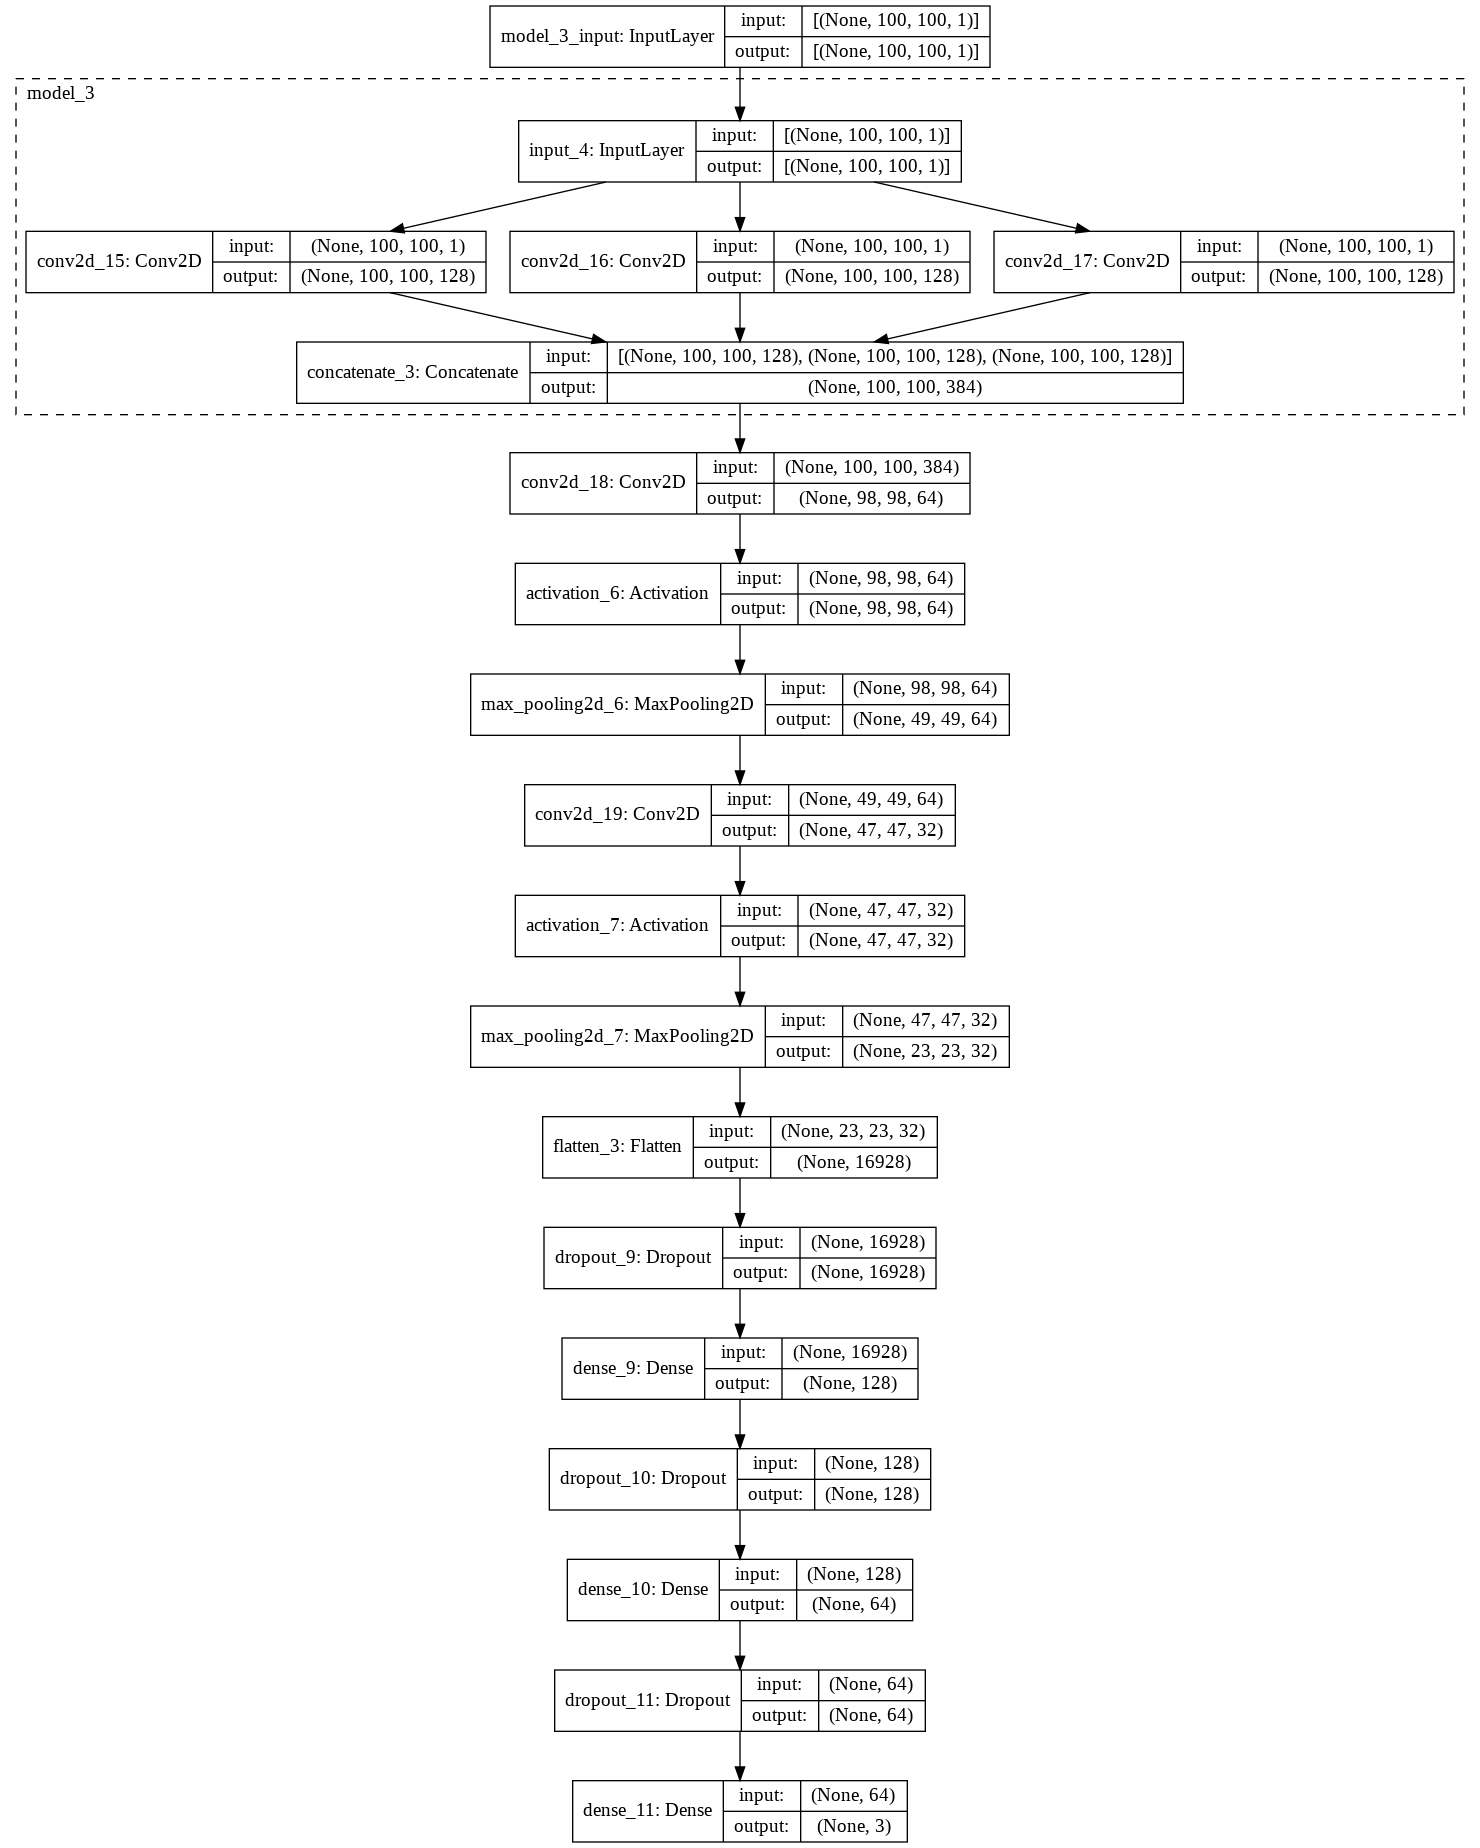

In [45]:
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [46]:
STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
STEP_SIZE_VALID=validation_dataset.n//validation_dataset.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

97
12


In [47]:
#Defining functions for early stopping and adjusting the learning rate during model training 
earlyStop = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose= 1)
learningRateReduce = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.4, min_lr=0.0000001)
callbacksList = [ earlyStop, learningRateReduce]

In [48]:
#Assigning class weights using the compute class weights function
classWeights = class_weight.compute_class_weight('balanced', np.unique(train_dataset.classes), train_dataset.classes)
classWeightsDict = dict(enumerate(classWeights))
print("The class weights to be assigned to each label are:", classWeightsDict)

The class weights to be assigned to each label are: {0: 1.0791666666666666, 1: 0.9664179104477612, 2: 0.9628252788104089}


In [49]:
history = model.fit(
    train_dataset, 
    steps_per_epoch = STEP_SIZE_TRAIN, 
    epochs=100,
    validation_data = validation_dataset,
    validation_steps = STEP_SIZE_VALID,
    class_weight = classWeightsDict,
    callbacks=callbacksList
    )

Epoch 1/100
97/97 [==============================] - 56s 528ms/step - loss: 1.0554 - accuracy: 0.4085 - val_loss: 0.6066 - val_accuracy: 0.8255
Epoch 2/100
97/97 [==============================] - 50s 517ms/step - loss: 0.6624 - accuracy: 0.6850 - val_loss: 0.3757 - val_accuracy: 0.8724
Epoch 3/100
97/97 [==============================] - 52s 537ms/step - loss: 0.5319 - accuracy: 0.7840 - val_loss: 0.3563 - val_accuracy: 0.8906
Epoch 4/100
97/97 [==============================] - 51s 519ms/step - loss: 0.4944 - accuracy: 0.8085 - val_loss: 0.3322 - val_accuracy: 0.8932
Epoch 5/100
97/97 [==============================] - 51s 522ms/step - loss: 0.4881 - accuracy: 0.8187 - val_loss: 0.3521 - val_accuracy: 0.8750
Epoch 6/100
97/97 [==============================] - 51s 524ms/step - loss: 0.4539 - accuracy: 0.8257 - val_loss: 0.2805 - val_accuracy: 0.9062
Epoch 7/100
97/97 [==============================] - 52s 531ms/step - loss: 0.3933 - accuracy: 0.8541 - val_loss: 0.2612 - val_accuracy:

In [50]:
model.save('ParallelSeqModel_ThreeLabelFinal.h5') #Saving the model

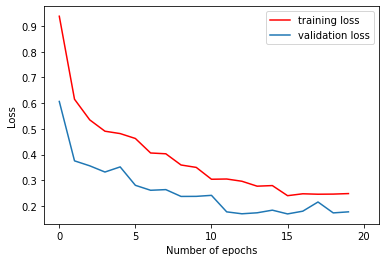

In [84]:
#Plotting the graph for training and validation loss
axes = plt.gca()
axes.set_xlim([-1, 21])
plt.locator_params(axis='x', integer=True, tight=True) #To ensure no. of epochs is shown as integers
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

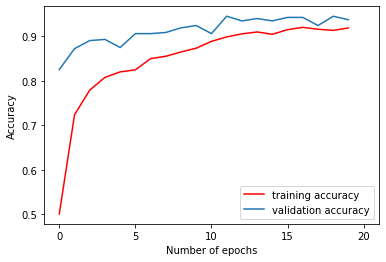

In [85]:
#Plotting the graph for training and validation accuracy
axes = plt.gca()
axes.set_xlim([-1, 21])
plt.locator_params(axis='x', integer=True, tight=True) #To ensure no. of epochs is shown as integers
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [86]:
testingAccuracy = model.evaluate(test_dataset) #Evaluating the model on the testing dataset
print("The Parallel Sequential Model has a testing accuracy of:", testingAccuracy[1]*100, "%")

10/10 [==============================] - 4s 393ms/step - loss: 0.2133 - accuracy: 0.9167
The Parallel Sequential Model has a testing accuracy of: 91.66666865348816 %
